In [1]:
import numpy as np
import os

from time import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from keras.preprocessing.image import load_img, array_to_img 
from keras.models import Model
from keras.layers import Conv2D, SeparableConv2D
from keras.layers import BatchNormalization, Activation, advanced_activations
from keras.layers import Input, MaxPooling2D, Add
from keras.layers import Conv2DTranspose, UpSampling2D

In [2]:
TRAIN_MODE = 1
EPOCH = 1000
BATCH_SIZE = 32

In [4]:
  with open('/content/drive/MyDrive/IDEC/arrays.npy', 'rb') as f:
      X_data = np.load(f)
      Y_data = np.load(f)

In [5]:
X_train, X_test, Y_train, Y_test = train_test_split(X_data,
                                                    Y_data,
                                                    test_size = 0.2)

print("Train Input Data :", X_train.shape)
print("Train Output Data :", Y_train.shape)
print("Test Input Data :", X_test.shape)
print("Test Output Data :", Y_test.shape)

Train Input Data : (952, 160, 160, 3)
Train Output Data : (952, 160, 160, 1)
Test Input Data : (238, 160, 160, 3)
Test Output Data : (238, 160, 160, 1)


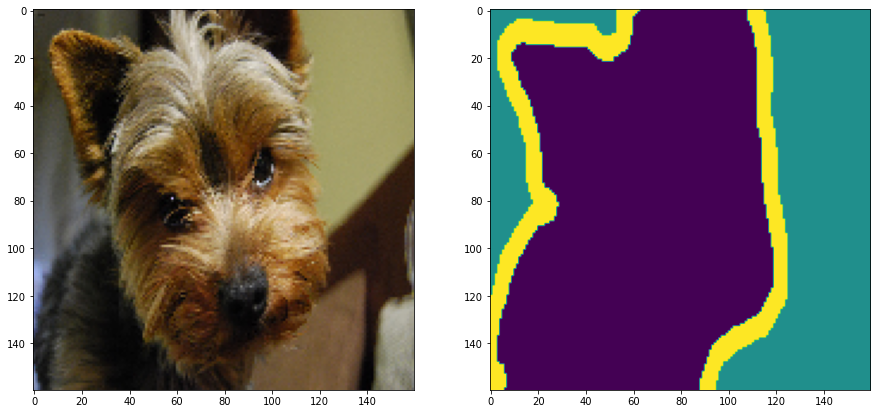

In [6]:
# Image show after Scaling
flg, spot = plt.subplots(1,2,figsize=(15,10)) 

# Color Image
img = array_to_img(X_data[1154])
spot[0].imshow(img)

# Edge Image
img = array_to_img(Y_data[1154])
spot[1].imshow(img)

Design Network

In [10]:
# U-Net Encoder
def build_encoder():
    inputs = Input(shape=(160, 160, 3))

    x = Conv2D(filters=32,
               kernel_size=3,
               strides=2,
               padding='same')(inputs)

    x = BatchNormalization()(x) # Normalizatoin : mean = 0, deviation = 1
    x = advanced_activations.LeakyReLU(alpha=0.2)(x)
    
    jump = x

    for filters in [64, 128, 256]:
        #x = advanced_activations.LeakyReLU(alpha=0.2)(x)

        # Conv1
        x = advanced_activations.LeakyReLU(alpha=0.2)(x)
        x = SeparableConv2D(filters,
                            kernel_size=3,
                            padding='same')(x)
        x = BatchNormalization()(x)

        # Conv2
        x = advanced_activations.LeakyReLU(alpha=0.2)(x)
        x = SeparableConv2D(filters,
                            kernel_size=3,
                            padding='same')(x)
        x = BatchNormalization()(x)

        # Pooling
        x = MaxPooling2D(pool_size=3,
                         strides=2,
                         padding='same')(x)
        
        # Residual
        residual = Conv2D(filters,
                          kernel_size=1,
                          strides=2,
                          padding='same')(jump)

        x = Add()([x, residual])
        jump = x

    return inputs, x


In [11]:
# U-Net Decoder
def build_decoder(inputs, x):
    # Residual
    jump = x

    # De-Conv
    for filters in [256, 128, 64, 32]:
        # Conv1
        x = advanced_activations.LeakyReLU(alpha=0.2)(x)
        x = Conv2DTranspose(filters,
                            kernel_size=3,
                            padding='same')(x)
        x = BatchNormalization()(x)
    
        # Conv2
        x = advanced_activations.LeakyReLU(alpha=0.2)(x)
        x = Conv2DTranspose(filters,
                            kernel_size=3,
                            padding='same')(x)
        x = BatchNormalization()(x)
        x = UpSampling2D(size=2)(x)

        # Residual
        residual = UpSampling2D(size=2)(jump)
        residual = Conv2D(filters,
                          kernel_size=1,
                          padding='same')(residual)

        x = Add()([x, residual])
        jump = x
        
    outputs = Conv2D(filters=3,
                     kernel_size=3,
                     activation='softmax',
                     padding='same')(x)

    model = Model(inputs, outputs)

    return model

In [13]:
inputs, link = build_encoder()
model = build_decoder(inputs, link)

<bound method Model.summary of <tensorflow.python.keras.engine.functional.Functional object at 0x7fca06195710>>

Train Model

In [14]:
# Train Model
if TRAIN_MODE:
    model.compile(optimizer='rmsprop',
                  loss='sparse_categorical_crossentropy')
    
    print("Start Train\n")
    begin = time()
    model.fit(X_train, Y_train, BATCH_SIZE, EPOCH, verbose=1)
    end = time()

    print("Learning TIme : {:.2f}".format(end-begin))
    model.save_weights('segment.h5')
else:
    model.load_weights('segment.h5')

Start Train

Epoch 1/1000
30/30 [==============================] - 46s 281ms/step - loss: 5.3320
Epoch 2/1000
30/30 [==============================] - 6s 214ms/step - loss: 0.8753
Epoch 3/1000
30/30 [==============================] - 6s 216ms/step - loss: 0.7538
Epoch 4/1000
30/30 [==============================] - 7s 217ms/step - loss: 0.6971
Epoch 5/1000
30/30 [==============================] - 7s 220ms/step - loss: 0.6575
Epoch 6/1000
30/30 [==============================] - 7s 221ms/step - loss: 0.5864
Epoch 7/1000
30/30 [==============================] - 7s 224ms/step - loss: 0.5649
Epoch 8/1000
30/30 [==============================] - 7s 226ms/step - loss: 0.5578
Epoch 9/1000
30/30 [==============================] - 7s 229ms/step - loss: 0.4928
Epoch 10/1000
30/30 [==============================] - 7s 230ms/step - loss: 0.4688
Epoch 11/1000
30/30 [==============================] - 7s 226ms/step - loss: 0.4236
Epoch 12/1000
30/30 [==============================] - 7s 224ms/step - 

Test Model

8/8 [==============================] - 0s 65ms/step


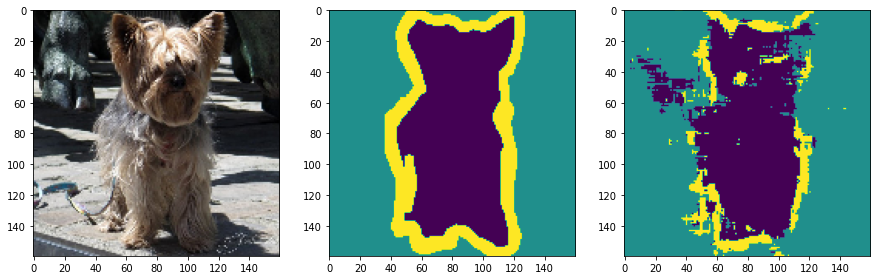

In [19]:
which = 236

fig, spot = plt.subplots(1, 3, figsize=(15,8))

img = array_to_img(X_test[which])
spot[0].imshow(img)

img = array_to_img(Y_test[which])
spot[1].imshow(img)

pred = model.predict(X_test, verbose=1)
mask = np.argmax(pred[which], axis=2)
mask = np.expand_dims(mask, axis=2)
img = array_to_img(mask)
spot[2].imshow(img)